# Line Broadening Module

**NOTE**: The class structure might still be needed later, so all of the explanations are kept here. For now, the convolution seems to work suprisingly smoothly. Worth exploring.

### Caltech Summer 2019

This notebook explores broadening of spectral lines as expected from FU Ori accretion disks. Now, I'll take the original code I developed for this and turn it into a class that will handle finding multiple lines to broaden carefully and precisely. This might get tricky. Started on 3 July 2019. 

Things to make sure you understand:
1. The integral of $\phi(\lambda)$ should be normalized to 1. This way, the amplitude of the broadened line is consistent.
2. Wherever the profile $\phi(\lambda)$ goes to infinity, the next points beyond that should be zero (the function has vertical asymptotes). So make sure those aren't being integrated in the convolution.
3. Integrate in your convolution past that limit of the vertical asymptotes to get their contribution in there as well.

### Imports 

In [1]:
import numpy as np
import astropy.io.fits as fits
from astropy.convolution import convolve, convolve_fft
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

### Constants (astronomy is in cgs, right?)

In [2]:
G = 6.67259e-8
SIG_SB = 5.67051e-5
M_SUN = 1.99e33
R_SUN = 6.96e10
L_SUN = 3.839e33
h_PLANCK = 6.6260755e-27
c_LIGHT = 2.99792458e10
k_BOLTZ = 1.380658e-16

## Toy spectrum

In [16]:
x = np.arange(3000e-8, 4060e-8 + 2e-9, 2e-9)
NOISE = 0.06*np.random.normal(0,1,len(x))

After giving each spectrum the same amount of noise, I will give different line widths, but the same line depths to demonstrate the difference.

In [17]:
MU = np.array([4010e-8, 4020e-8, 4035e-8, 4045e-8])
AMP = np.array([0.4, 0.6, 0.5, 0.7])

SIG_VALS = np.array([0.5])*1e-8

In [18]:
def gaussianFeature(x, mu, sig, amp):
    return -amp*np.exp(-0.5*((x-mu)/sig)**2)

def createToySpectra(x, mu, sig_arr, amp, noise):
    res = []
    for i in range(len(sig_arr)):
        spec = np.zeros(len(x))
        if noise:
            spec += NOISE
        for j in range(len(mu)):
            spec += gaussianFeature(x, mu[j], sig_arr[i], amp[j]) + 5e5*(x-4020e-8) - 1e12*(x-4000e-8)**2
        res.append(spec)

    return res
        

In [19]:
spectra = createToySpectra(x, MU, SIG_VALS, AMP, noise=True)

In [20]:
wav, lum = x*1e8, spectra[0]

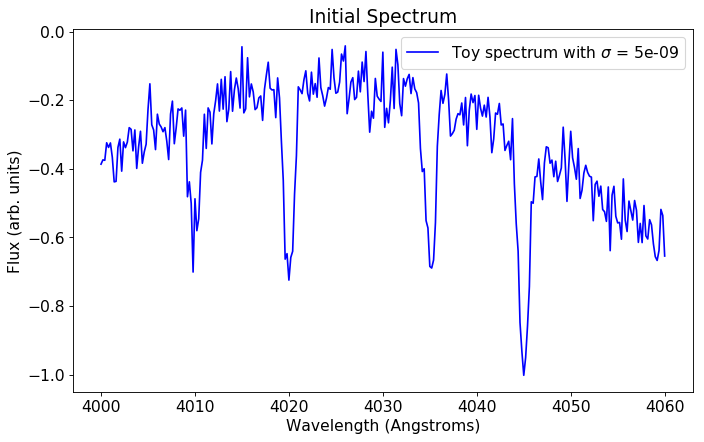

In [25]:
fig=plt.figure(figsize=(10, 6), dpi= 80)
plt.rcParams.update({'font.size': 14})
plt.plot(wav[5000:], lum[5000:], 'b-', label=r'Toy spectrum with $\sigma$ = ' + str(SIG_VALS[0]))

plt.title('Initial Spectrum')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flux (arb. units)')
plt.legend()
plt.show()

# Starting point for code needed to be transferred

If given a spectrum, $\texttt{setSpecHeight}$ shifts it along the vertical axis to any value.

In [26]:
def setSpecHeight(amps, val):
    max_amp = np.max(amps)
    return amps - max_amp + val

def dopplerProfileNorm(l, l_0, r, inc):
    l_out = np.zeros(len(l))
    v = (G*M_SUN/r)**(1/2) - 2e-5*(G*M_SUN/r)**(0.8)
    lmax = (l_0*v*np.sin(inc)/c_LIGHT)
    for i in range(len(l)):
        if np.abs(l[i]-l_0) < lmax:
            norm_fac = (1/(np.pi*lmax))
            l_out[i] = norm_fac*(1 - ((l[i]-l_0)/lmax)**2)**(-1/2)
    return l_out

In [27]:
def instProfileNorm(waves, wave_0, width):
    waves = waves*1e-8
    wave_0 = wave_0*1e-8
    f_out = np.zeros(len(waves))
    wave_max = (wave_0*width/c_LIGHT)
    for i in range(len(waves)):
        if np.abs(waves[i]-wave_0) < wave_max:
            f_out[i] = (1/(np.pi*wave_max))*np.exp(-((waves[i]-wave_0)/wave_max)**2)
    return f_out 

In [28]:
from astropy.convolution import Trapezoid1DKernel, Gaussian1DKernel

In [29]:
WAVE_TOY = x
AMPS_TOY = spectra
DIST = 10
INC = 80

In [30]:
dopp_arr = dopplerProfileNorm(WAVE_TOY, np.mean(WAVE_TOY), DIST*R_SUN, np.radians(INC)) 
# dopp_arr = Trapezoid1DKernel(20)
gauss_arr = AMPS_TOY

In [31]:
conv_arr = [convolve(gauss_arr[i], dopp_arr) for i in range(len(gauss_arr))]
conv_arr_2 = [convolve(gauss_arr[i]+100, dopp_arr) for i in range(len(gauss_arr))]

In [34]:
conv_arr_2[0]-100

array([-274.3135787 , -303.49497434, -334.75168485, ...,  -27.05260657,
        -36.78345066,  -45.85923166])

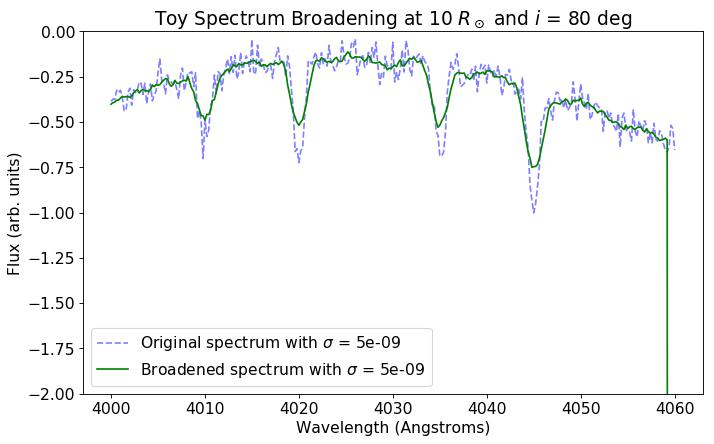

In [35]:
fig=plt.figure(figsize=(10, 6), dpi= 80)
plt.rcParams.update({'font.size': 14})
plt.plot(WAVE_TOY[5000:]*1e8, AMPS_TOY[0][5000:], 'b--', alpha=0.5,label=r'Original spectrum with $\sigma$ = ' + str(SIG_VALS[0])) 
plt.plot(WAVE_TOY[5000:]*1e8,conv_arr_2[0][5000:]-100, 'g-',label=r'Broadened spectrum with $\sigma$ = ' + str(SIG_VALS[0]))

# plt.plot(WAVE_TOY*1e8, dopp_arr*1e-8, 'm-', label='Doppler convolution')
# plt.plot(WAVE_TOY*1e8, AMPS_TOY[1], 'g--',alpha=0.5, label=r'Original spectrum with $\sigma$ = ' + str(SIG_VALS[1]))
# plt.plot(WAVE_TOY*1e8,conv_arr[1],'g-', label=r'Broadened spectrum with $\sigma$ = ' + str(SIG_VALS[1]))

# plt.plot(wav2, lum2, 'r--', label='Continuum profile?')


plt.title(r'Toy Spectrum Broadening at ' + str(DIST) + ' $R_\odot$ and $i$ = ' + str(INC) + ' deg')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flux (arb. units)')
plt.ylim(-2,0)
plt.legend()
plt.show()

In [155]:
def tick_function(wave, central):
    v = (wave - central)*c_LIGHT*1e-5/central
    return ["%.0f" % int(z) for z in v]

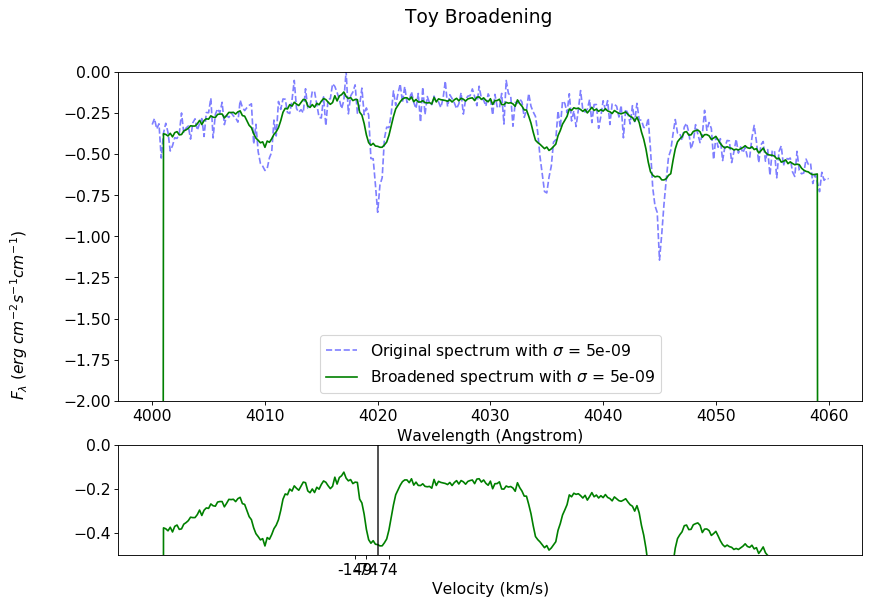

In [160]:
fig=plt.figure(figsize=(12, 8), dpi= 80)
gs = gridspec.GridSpec(2, 1,height_ratios=[3, 1])

ax = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

ax.plot(WAVE_TOY*1e8, AMPS_TOY[0], 'b--', alpha=0.5,label=r'Original spectrum with $\sigma$ = ' + str(SIG_VALS[0])) 
ax.plot(WAVE_TOY*1e8,conv_arr_2[0]-100, 'g-',label=r'Broadened spectrum with $\sigma$ = ' + str(SIG_VALS[0]))
ax.set_xlabel('Wavelength (Angstrom)')
ax.legend()

ax2.plot(WAVE_TOY*1e8,conv_arr_2[0]-100, 'g-',label=r'Broadened spectrum with $\sigma$ = ' + str(SIG_VALS[0]))
ax2.axvline(4020, color='k', alpha=0.8)


plt.suptitle('Toy Broadening')
fig.text(0.01, 0.5, r'$F_\lambda\; (erg \;cm^{-2} s^{-1} cm^{-1})$', va='center', rotation='vertical')
ax.set_ylim(-2,0)
ax2.set_ylim(-0.5,0)
# ax2.set_xlim(4010, 4030)


new_tick_locations = np.array([4018, 4019, 4021])
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(tick_function(new_tick_locations, 4020))


ax2.set_xlabel('Velocity (km/s)')


plt.show()


In [135]:
auio = np.array([4000, 4010, 4020])

In [136]:
buio = auio - 10

In [137]:
cuio = auio + 10

In [140]:
np.concatenate((auio, buio, cuio))

array([4000, 4010, 4020, 3990, 4000, 4010, 4010, 4020, 4030])